## Improving Phishing Techniques with Machine Learning



The aim of this project is to improve phishing detection and classfification with machine learning techniques. The study will focus on the use of textual data for model training and gain insight into how textual data is processed for the machine to perform classification. 

Natural Language Processing was explored in the extraction of feature from the text content and features were tested using seven machine learning algorithms.

    1. Decision Tree    
    2. Logistics Regression
    3. Support Vector Machine
    4. Random Forest
    5. K-Nearest Neighbor
    6. Adaptive Boosting
    7. XGBoost

In processing the data, there was an endeavour to preseve the original components of the data as we believe that will make a difference in the feature extraction

In [2]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

#for feature engineering
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


#import to split train and test data
from sklearn.model_selection import train_test_split

#import for Ml classfifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree

#import for prediction evaluation
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score
from sklearn.metrics import roc_curve, auc

#import for hyperparamter optimization
from sklearn.model_selection import GridSearchCV
#import for text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#### Loading Dataset 

In [3]:
#loading the dataset into a dataframe
email_phish = pd.read_csv("C:\\Users\E7470\OneDrive - Robert Gordon University\Documents\Term 3\Dataset\email dataset\spamham2.csv", dtype={'Email Content': str})
email_phish.head()

,Email Content,Label
0,thank you .,ham
1,"sally : what timing , ask and you shall receiv...",ham
2,"over the next few weeks , project apollo and b...",ham
3,a ) year end reviews - report needs generating...,ham
4,"good morning , i ' d love to go get some coffe...",ham


In [4]:
#check for number of rows and columns in the dataset befor any processing
email_phish.shape

(32784, 2)

In [5]:
#check for balance of spam and ham email befor any processing
email_phish['Label'].value_counts()

ham     16623
spam    16081
Name: Label, dtype: int64

In [6]:
#identifying any null values
email_phish.isnull().sum()

Email Content    450
Label             80
dtype: int64

In [7]:
email_phish.dropna(inplace=True)

In [8]:
#check for number of rows and columns in the dataset 
email_phish.shape

(32254, 2)

In [9]:
#check for balance of spam and ham email
email_phish['Label'].value_counts()

ham     16492
spam    15762
Name: Label, dtype: int64

####  Exploratory Data Analysis

Creating new features that can be used for exploratory data analysis
- Number of characters in text such as punctuation
- Number of words in text
- Number of sentences in text

In [93]:
#Adding a column of numbers of charachters,words and sentences in each mail
email_phish['no_char'] = email_phish['Email Content'].apply(len)
email_phish['no_words'] = email_phish['Email Content'].apply(lambda x: len(nltk.word_tokenize(x)))
email_phish['no_sent'] = email_phish['Email Content'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [94]:
email_phish.head()

,Email Content,Label,no_char,no_words,no_sent
0,thank you .,ham,11,3,1
1,"sally : what timing , ask and you shall receiv...",ham,3511,754,27
2,"over the next few weeks , project apollo and b...",ham,3607,666,28
3,a ) year end reviews - report needs generating...,ham,300,56,3
4,"good morning , i ' d love to go get some coffe...",ham,1004,239,21


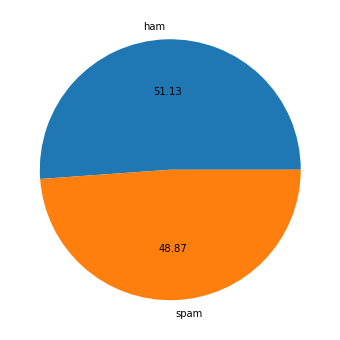

In [95]:
#distribution of target variable
plt.figure(figsize=(12,6))
plt.pie(email_phish['Label'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

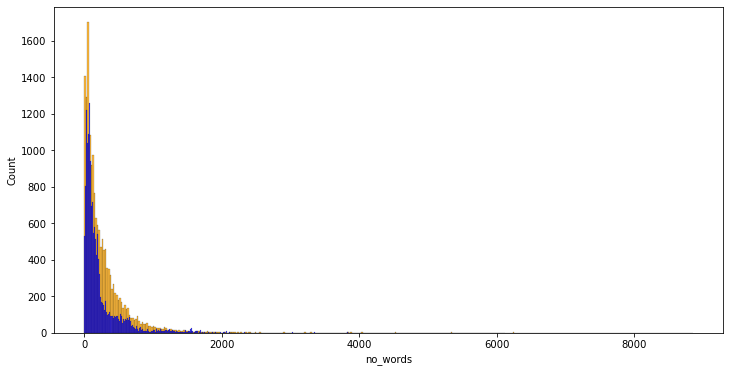

In [96]:
#distribution of words
plt.figure(figsize=(12,6))
sns.histplot(email_phish[email_phish['Label'] == 'ham']['no_words'], color = 'orange')
sns.histplot(email_phish[email_phish['Label'] == 'spam']['no_words'], color = 'blue')
plt.show()

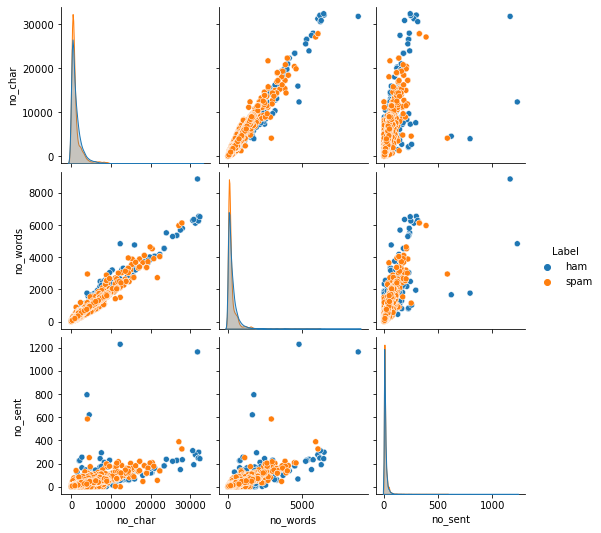

In [13]:
sns.pairplot(email_phish, hue='Label')
plt.show()

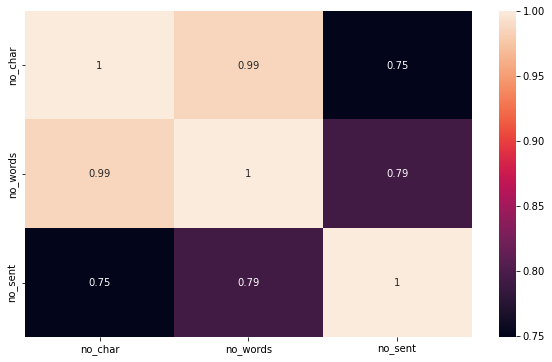

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(email_phish.corr(), annot=True)
plt.show()

In [15]:
cloud_ham = email_phish[email_phish.Label=='ham']
cloud_spam = email_phish[email_phish.Label=='spam']

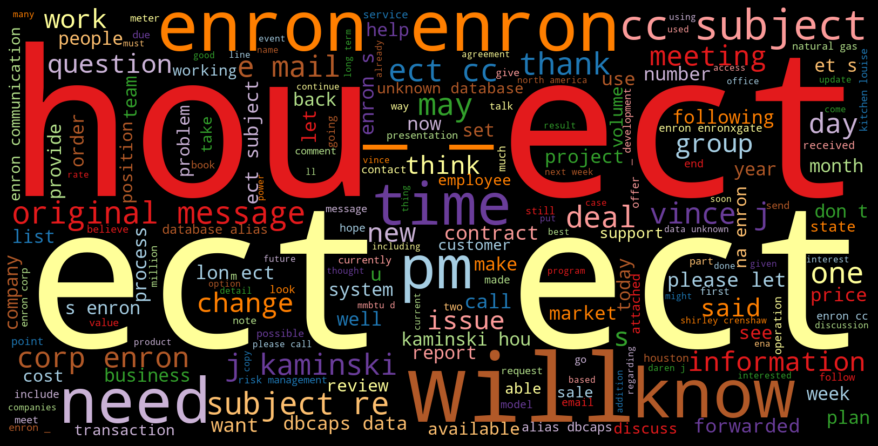

In [16]:
ham_content = " ".join(i for i in cloud_ham['Email Content'])
wordcloud = WordCloud(width=1600, height =800, colormap='Paired').generate(ham_content)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

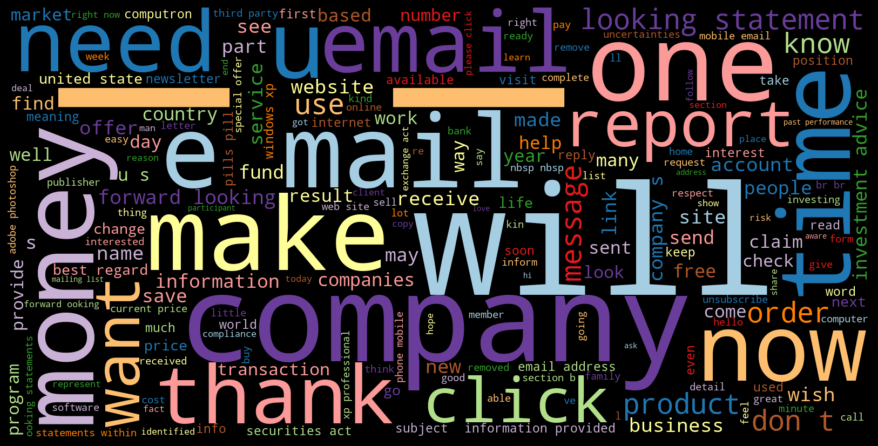

In [17]:
spam_content = " ".join(i for i in cloud_spam['Email Content'])
wordcloud = WordCloud(width=1600, height =800, colormap='Paired').generate(spam_content)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Data Engineering 

In [10]:
#using the numpy char module to convert all text to lowercase
email_content = email_phish['Email Content']
def lower_case(email_content):
    return np.char.lower(email_content)

In [11]:
#using the nltk stop words to remove stop words and tokenize
def del_stop_words(email_content):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(email_content))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


In [12]:
#using the char function to remove punction and spec characters
def remove_punctuation(email_content):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        email_content = np.char.replace(email_content, symbols[i], ' ')
        email_content = np.char.replace(email_content, "  ", " ")
    data = np.char.replace(email_content, ',', '')
    return email_content

In [13]:
#stemmatization using PortStemmer
def stemm(email_content):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(email_content))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

In [14]:
#lemmatization using WordNetlemmatizer
def lemma(email_content):
    lemma= WordNetLemmatizer()
    
    tokens = word_tokenize(str(email_content))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemma.lemmatize(w)
    return new_text

In [15]:
def preprocess(email_content):
    email_content = lower_case(email_content)
    email_content = del_stop_words(email_content)
    email_content = remove_punctuation(email_content)
    email_content = stemm(email_content)
    email_content = lemma(email_content)
    return email_content

In [16]:
def apply_preprocess(series):
    preprocessed_data = series.apply(preprocess)
    return preprocessed_data

In [17]:
data = apply_preprocess(email_phish['Email Content'])
print(data)

0                                                    thank
1         salli time ask shall receiv per discus list u...
2         next week project apollo beyond conduct final...
3         year end review report need gener like mid ye...
4         good morn love go get coffe rememb annoy proj...
                               ...                        
32779     gener viagra find everyon switch ideal solut ...
32780          learn last 10 time longer bed read plod net
32781     free date site fill ton sex addict flower gif...
32782     hi need softwar give link http zk net softyou...
32783     html bodi pwhi take look plose weight week pa...
Name: Email Content, Length: 32254, dtype: object


#### Split Dataset - Train & Test

In [18]:
#setting email content and identifying label in variable
X = data
Y = email_phish['Label']

In [19]:
#splitting test size into 80/20, shuffle the data due to data balancing
X_trainset, X_testset, Y_trainset, Y_testset = train_test_split(X,Y, test_size=0.2, random_state= 3, shuffle = True)

#### Feature Extraction using TF-IDF

This will be tansforming the contents of the email into vectors that can be used as inputs in our different models. Using TF-IDF, we are able to score words based on their frequency in the content

In [20]:
#creating an instance of the TfidfVectorizer with 1 parameter
feature_extraction = TfidfVectorizer(min_df = 2)
#setting the vectorizer to ignore words with score lower than 1

#transforming the training data into a matrix of TF-IDF features
X_trainset_features = feature_extraction.fit_transform(X_trainset)
X_testset_features = feature_extraction.transform(X_testset)

feature_names = feature_extraction.get_feature_names_out(X_trainset_features)
df = pd.DataFrame(feature_names).to_numpy()
print(df)


from sklearn.preprocessing import LabelEncoder
#encoding the labels, this is done differently to avoid leakage and overfitting
encode = LabelEncoder()
Y_trainset = encode.fit_transform(Y_trainset)
Y_testset = encode.fit_transform(Y_testset)

Y_testset_decode = encode.inverse_transform(Y_testset)
print('Encoded labels: ', Y_testset[0:5])
print('Decoded labels: ', Y_testset_decode[0:5])

[['00']
 ['000']
 ['0000']
 ...
 ['zzucpkow']
 ['zzxtfeerekvwkug']
 ['zzzz']]
Encoded labels:  [1 1 0 0 0]
Decoded labels:  ['spam' 'spam' 'ham' 'ham' 'ham']


The output of the feature extraction using the TF-IDF Vectorizer will be a sparse matrix with each row representing a text from the dataset and each column is representative of a unique word appearing in at least one text.


### Models Training and Evaluation 

#### Random Forest Classifier 

In [21]:
#training and fitting the model

rng = np.random.RandomState(0)

rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state = rng)

rf.fit(X_trainset_features, Y_trainset)

RandomForestClassifier(n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x245827EDE40)

In [22]:
#evaluating trained model
rf_train =rf.predict(X_trainset_features)
rf_train_acc = accuracy_score(Y_trainset, rf_train)

print("Accuracy on training data: " , rf_train_acc)

#evaluating accuracy on test data
rf_test = rf.predict(X_testset_features)
rf_test_acc = accuracy_score(Y_testset,rf_test)

print("Accuracy on test data: " , rf_test_acc)

Accuracy on training data:  0.9997287137154595
Accuracy on test data:  0.9874438071616803


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3349
           1       0.98      0.99      0.99      3102

    accuracy                           0.99      6451
   macro avg       0.99      0.99      0.99      6451
weighted avg       0.99      0.99      0.99      6451



Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix - TFIDF')

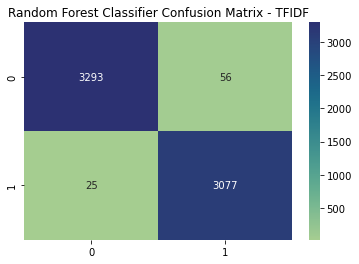

In [77]:
#Evaluating the classficiation
rf_class_report = (classification_report(Y_testset, rf_test))
print(rf_class_report)

rf_CM = confusion_matrix(Y_testset, rf_test)
sns.heatmap(rf_CM, annot = True, fmt='d', cmap='crest')
plt.title("Random Forest Classifier Confusion Matrix - TFIDF")

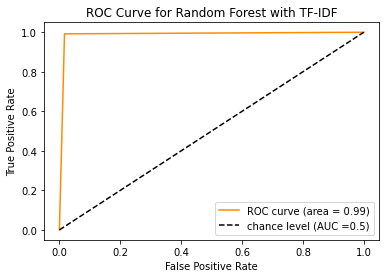

In [24]:
#calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_testset, rf_test)

#calculating auc
rf_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest with TF-IDF')
plt.legend()
plt.show()

#### K Neighbor Classifier

In [25]:
#training and fitting the model

knc= KNeighborsClassifier()

knc.fit(X_trainset_features, Y_trainset)

KNeighborsClassifier()

In [26]:
#evaluating trained model
knc_train = knc.predict(X_trainset_features)
knc_train_acc = accuracy_score(Y_trainset, knc_train)

print("Accuracy on training data: " , knc_train_acc)

#evaluating accuracy on test data
knc_test = knc.predict(X_testset_features)
knc_test_acc = accuracy_score(Y_testset,knc_test)

print("Accuracy on test data: " , knc_test_acc)

Accuracy on training data:  0.7405728016122156
Accuracy on test data:  0.6740040303828864


              precision    recall  f1-score   support

           0       0.99      0.38      0.54      3349
           1       0.60      1.00      0.75      3102

    accuracy                           0.67      6451
   macro avg       0.79      0.69      0.65      6451
weighted avg       0.80      0.67      0.64      6451



Text(0.5, 1.0, 'K-Neighbors Confusion Matrix - TFIDF')

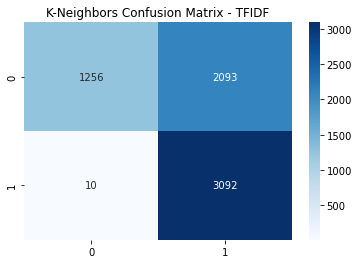

In [113]:
#Evaluating the classficiation 
knc_class_report = (classification_report(Y_testset, knc_test))
print(knc_class_report)

knc_CM = confusion_matrix(Y_testset, knc_test)
sns.heatmap(knc_CM, annot = True, fmt='d', cmap='Blues')
plt.title("K-Neighbors Confusion Matrix - TFIDF")

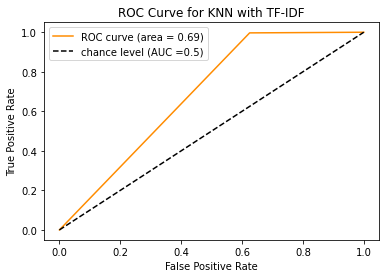

In [115]:
fpr, tpr, thresholds = roc_curve(Y_testset, knc_test)

#calculating auc
knc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % knc_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN with TF-IDF')
plt.legend()
plt.show()

Using the Elbow method, we can determine the best value for K. This method will be implemented to optimize the value of k by creating a loop to train through with different K value to determine error rate

#### Decision Tree Classifier

In [29]:
#training and fitting the model
dtc= DecisionTreeClassifier()

dtc.fit(X_trainset_features, Y_trainset)

DecisionTreeClassifier()

In [30]:
#evaluating trained model
dtc_train = dtc.predict(X_trainset_features)
dtc_train_acc = accuracy_score(Y_trainset, dtc_train)

print("Accuracy on training data: " , dtc_train_acc)

#evaluating accuracy on test data
dtc_test = dtc.predict(X_testset_features)
dtc_test_acc = accuracy_score(Y_testset,dtc_test)

print("Accuracy on test data: " , dtc_test_acc)

Accuracy on training data:  0.9997674688989653
Accuracy on test data:  0.960006200589056


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3349
           1       0.96      0.96      0.96      3102

    accuracy                           0.96      6451
   macro avg       0.96      0.96      0.96      6451
weighted avg       0.96      0.96      0.96      6451



Text(0.5, 1.0, 'Decision Tree Classifier Confusion Matrix - TFIDF')

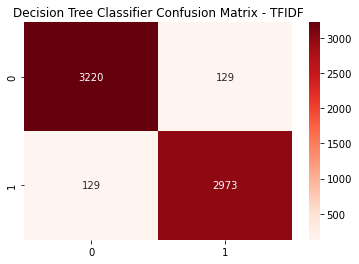

In [116]:
#Evaluating the classficiation 
dtc_class_report = (classification_report(Y_testset, dtc_test))
print(dtc_class_report)

dtc_CM = confusion_matrix(Y_testset, dtc_test)
sns.heatmap(dtc_CM, annot = True, fmt='d', cmap='Reds')
plt.title("Decision Tree Classifier Confusion Matrix - TFIDF")

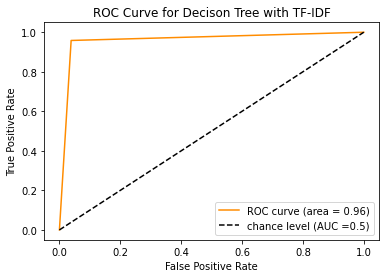

In [117]:
fpr, tpr, thresholds = roc_curve(Y_testset, dtc_test)

#calculating auc
dtc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % dtc_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decison Tree with TF-IDF')
plt.legend()
plt.show()

#### Support Vector Machine

In [32]:
#the parmeter set to introudce its handing od high deminsion sparse matrix
svm = SVC(kernel = 'linear', C = 1, gamma = 'scale')

#training the model
svm.fit(X_trainset_features, Y_trainset)

SVC(C=1, kernel='linear')

In [33]:
#evaluating trained model
svm_train =svm.predict(X_trainset_features)
svm_train_acc = accuracy_score(Y_trainset, svm_train)

print("Accuracy on training data: " , svm_train_acc)

#evaluating accuracy on test data
svm_test = svm.predict(X_testset_features)
svm_test_acc = accuracy_score(Y_testset,svm_test)

print("Accuracy on test data: " , svm_test_acc)

Accuracy on training data:  0.997558423439135
Accuracy on test data:  0.9902340722368626


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3349
           1       0.98      1.00      0.99      3102

    accuracy                           0.99      6451
   macro avg       0.99      0.99      0.99      6451
weighted avg       0.99      0.99      0.99      6451



Text(0.5, 1.0, 'Support Vector Machine Confusion Matrix - TFIDF')

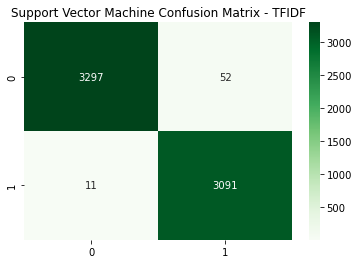

In [34]:
#Evaluating the classficiation 
svm_class_report = (classification_report(Y_testset, svm_test))
print(svm_class_report)

svm_CM = confusion_matrix(Y_testset, svm_test)
sns.heatmap(svm_CM, annot = True, fmt='d', cmap='Greens')
plt.title("Support Vector Machine Confusion Matrix - TFIDF")

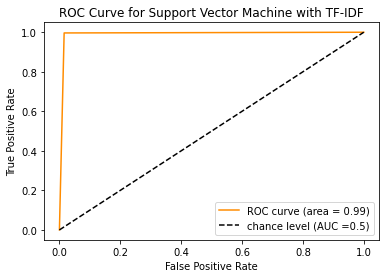

In [35]:
fpr, tpr, thresholds = roc_curve(Y_testset, svm_test)

#calculating auc
svm_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Support Vector Machine with TF-IDF')
plt.legend()
plt.show()

#### Logistic Regression

In [36]:
lr = LogisticRegression(penalty='l2', C=1.0)

#training the model
lr.fit(X_trainset_features, Y_trainset)

LogisticRegression()

In [37]:
#evaluating trained model
lr_train = lr.predict(X_trainset_features)
lr_train_acc = accuracy_score(Y_trainset, lr_train)

print("Accuracy on training data: " , lr_train_acc)

#evaluating accuracy on test data
lr_test = lr.predict(X_testset_features)
lr_test_acc = accuracy_score(Y_testset, lr_test)

print("Accuracy on test data: " , lr_test_acc)

Accuracy on training data:  0.9895748556369415
Accuracy on test data:  0.9829483800961091


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3349
           1       0.97      1.00      0.98      3102

    accuracy                           0.98      6451
   macro avg       0.98      0.98      0.98      6451
weighted avg       0.98      0.98      0.98      6451



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix - TFIDF')

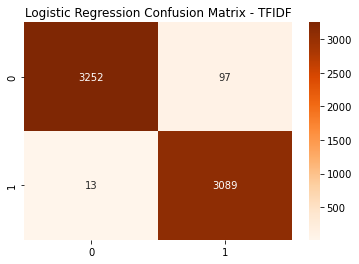

In [38]:
#Evaluating the classficiation 
lr_class_report = (classification_report(Y_testset, lr_test))
print(lr_class_report)

lr_CM = confusion_matrix(Y_testset, lr_test)
sns.heatmap(lr_CM, annot = True, fmt='d', cmap='Oranges')
plt.title("Logistic Regression Confusion Matrix - TFIDF")

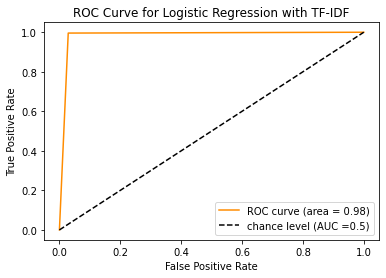

In [39]:
fpr, tpr, thresholds = roc_curve(Y_testset, lr_test)

#calculating auc
lr_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % lr_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with TF-IDF')
plt.legend()
plt.show()

#### XG Boost

In [40]:
xgb = XGBClassifier()

#training the model
xgb.fit(X_trainset_features, Y_trainset)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
#evaluating trained model
xgb_train = xgb.predict(X_trainset_features)
xgb_train_acc = accuracy_score(Y_trainset, xgb_train)

print("Accuracy on training data: " , xgb_train_acc)

#evaluating accuracy on test data
xgb_test = xgb.predict(X_testset_features)
xgb_test_acc = accuracy_score(Y_testset,xgb_test)

print("Accuracy on test data: " , xgb_test_acc)

Accuracy on training data:  0.9870557687090649
Accuracy on test data:  0.9826383506433111


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3349
           1       0.97      1.00      0.98      3102

    accuracy                           0.98      6451
   macro avg       0.98      0.98      0.98      6451
weighted avg       0.98      0.98      0.98      6451



Text(0.5, 1.0, 'XGBoost Confusion Matrix - TFIDF')

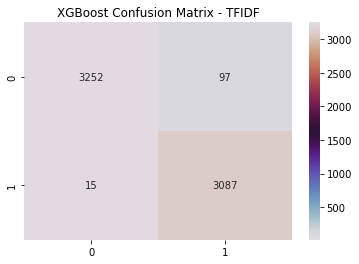

In [42]:
#Evaluating the classficiation 
xgb_class_report = (classification_report(Y_testset, xgb_test))
print(xgb_class_report)

xgb_CM = confusion_matrix(Y_testset, xgb_test)
sns.heatmap(xgb_CM, annot = True, fmt='d', cmap='twilight')
plt.title("XGBoost Confusion Matrix - TFIDF")

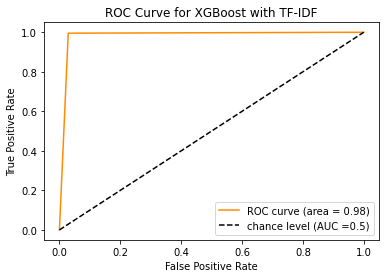

In [43]:
fpr, tpr, thresholds = roc_curve(Y_testset, xgb_test)

#calculating auc
xgb_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % xgb_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost with TF-IDF')
plt.legend()
plt.show()

#### Adaptive Boosting Classifier

In [44]:
adb = AdaBoostClassifier()

#training the model
adb.fit(X_trainset_features, Y_trainset)

AdaBoostClassifier()

In [45]:
#evaluating trained model
adb_train = xgb.predict(X_trainset_features)
adb_train_acc = accuracy_score(Y_trainset, adb_train)

print("Accuracy on training data: " , adb_train_acc)

#evaluating accuracy on test data
adb_test = adb.predict(X_testset_features)
adb_test_acc = accuracy_score(Y_testset,adb_test)

print("Accuracy on test data: " , adb_test_acc)

Accuracy on training data:  0.9870557687090649
Accuracy on test data:  0.9468299488451403


              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3349
           1       0.94      0.96      0.95      3102

    accuracy                           0.95      6451
   macro avg       0.95      0.95      0.95      6451
weighted avg       0.95      0.95      0.95      6451



Text(0.5, 1.0, 'AdaBoost Confusion Matrix - TFIDF')

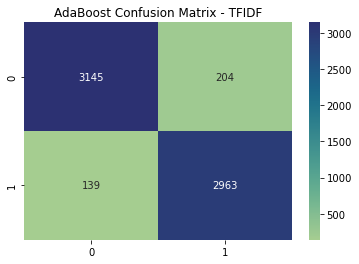

In [46]:
#Evaluating the classficiation 
adb_class_report = (classification_report(Y_testset, adb_test))
print(adb_class_report)

adb_CM = confusion_matrix(Y_testset, adb_test)
sns.heatmap(adb_CM, annot = True, fmt='d', cmap='crest')
plt.title("AdaBoost Confusion Matrix - TFIDF")

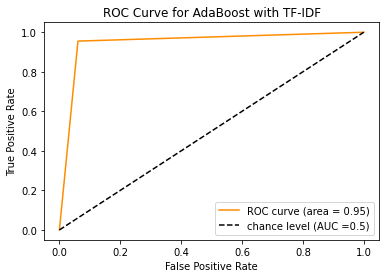

In [47]:
fpr, tpr, thresholds = roc_curve(Y_testset, adb_test)

#calculating auc
adb_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % adb_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost with TF-IDF')
plt.legend()
plt.show()

#### Evaluation of Models


In [118]:
for_models_predicted = ['Random Forest(RF)','K Nearest Neighbors (KNN)','Decision Tree (DT)',
                   'Support Vector (SV)', 'Logistics Regression (LR)','XGBOOST (XGB)','AdaBoost (ADB)']
classification_reports = [rf_class_report, knc_class_report, dtc_class_report, svm_class_report,
                       lr_class_report, xgb_class_report, adb_class_report]
for i, model_name in enumerate(for_models_predicted):
    print(f"Classification report for {model_name} with TF-IDF")
    print(classification_reports[i])

Classification report for Random Forest(RF) with TF-IDF
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3349
           1       0.98      0.99      0.99      3102

    accuracy                           0.99      6451
   macro avg       0.99      0.99      0.99      6451
weighted avg       0.99      0.99      0.99      6451

Classification report for K Nearest Neighbors (KNN) with TF-IDF
              precision    recall  f1-score   support

           0       0.99      0.38      0.54      3349
           1       0.60      1.00      0.75      3102

    accuracy                           0.67      6451
   macro avg       0.79      0.69      0.65      6451
weighted avg       0.80      0.67      0.64      6451

Classification report for Decision Tree (DT) with TF-IDF
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3349
           1       0.96      0.96      0.96      3102

    a

In [119]:
for_models_predicted = ['Random Forest(RF)','K Nearest Neighbors (KNN)','Decision Tree (DT)',
                   'Support Vector (SV)', 'Logistics Regression (LR)','XGBOOST (XGB)','AdaBoost (ADB)']
acc_list = [rf_test_acc, knc_test_acc, dtc_test_acc, svm_test_acc,
                       lr_test_acc, xgb_test_acc, adb_test_acc]

result = pd.DataFrame({'Models with TF-IDF':for_models_predicted,'Accuracy %': acc_list})
result.set_index('Models with TF-IDF',inplace=True)
result


,Accuracy %
Models with TF-IDF,
Random Forest(RF),0.987444
K Nearest Neighbors (KNN),0.674004
Decision Tree (DT),0.960006
Support Vector (SV),0.990234
Logistics Regression (LR),0.982948
XGBOOST (XGB),0.982638
AdaBoost (ADB),0.946830


#### Implementing GridSearch for Logistics Regression
Implementing GridSearch to identify a more compatible combination of paramters that may likely increase the accuracy of predictionof our model 


In [64]:
lr_Gr = LogisticRegression(max_iter = 20000, solver = 'lbfgs', class_weight = 'balanced' )
param = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
clf_lr = GridSearchCV(lr_Gr, param_grid= param, cv = 5, n_jobs=-1).fit(X_trainset_features, Y_trainset)

In [65]:
clf_lr.best_params_

clf_lr.best_estimator_

LogisticRegression(C=100, class_weight='balanced', max_iter=20000)

In [66]:
clf_lr_pred = clf_lr.predict(X_testset_features)
lr_detect = accuracy_score(Y_testset, clf_lr_pred)

print("Accuracy on test data: " , lr_detect)

Accuracy on test data:  0.9910091458688576


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3349
           1       0.98      1.00      0.99      3102

    accuracy                           0.99      6451
   macro avg       0.99      0.99      0.99      6451
weighted avg       0.99      0.99      0.99      6451



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix with GridSearch - TFIDF')

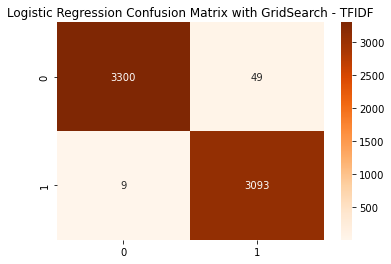

In [67]:
#Evaluating the classficiation 
lrGr_class_report = (classification_report(Y_testset, clf_lr_pred))
print(lrGr_class_report)

clf_lr_CM = confusion_matrix(Y_testset, clf_lr_pred)
sns.heatmap(clf_lr_CM, annot = True, fmt='d', cmap='Oranges')
plt.title("Logistic Regression Confusion Matrix with GridSearch - TFIDF")

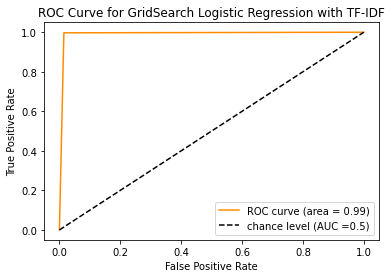

In [69]:
fpr, tpr, thresholds = roc_curve(Y_testset, clf_lr_pred)

#calculating auc
clf_lr_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % clf_lr_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GridSearch Logistic Regression with TF-IDF')
plt.legend()
plt.show()

### Implementing GridSearch for SVM

In [71]:
svc_gr = SVC(class_weight='balanced',probability=True, verbose=True)
parameters = {'C':[0.1, 1, 10]}
clf_svc = GridSearchCV(svc_gr, parameters, cv = 5, n_jobs=-1).fit(X_trainset_features, Y_trainset)

[LibSVM]

In [72]:
clf_svc.best_params_

clf_svc.best_estimator_

SVC(C=10, class_weight='balanced', probability=True, verbose=True)

In [73]:
clf_svc_pred = clf_svc.predict(X_testset_features)
svc_detect = accuracy_score(Y_testset, clf_svc_pred)

print("Accuracy on test data: " , svc_detect)

Accuracy on test data:  0.9902340722368626


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3349
           1       0.98      1.00      0.99      3102

    accuracy                           0.99      6451
   macro avg       0.99      0.99      0.99      6451
weighted avg       0.99      0.99      0.99      6451



Text(0.5, 1.0, 'Support Vector Machine Confusion Matrix with GridSearch - TFIDF')

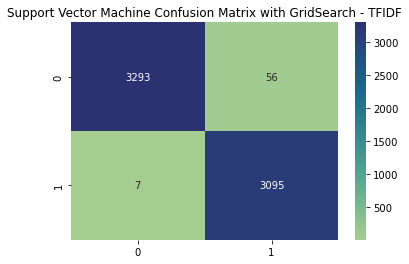

In [74]:
#Evaluating the classficiation 
svcGr_class_report = (classification_report(Y_testset, clf_svc_pred))
print(svcGr_class_report)

clf_svc_CM = confusion_matrix(Y_testset, clf_svc_pred)
sns.heatmap(clf_svc_CM, annot = True, fmt='d', cmap='crest')
plt.title("Support Vector Machine Confusion Matrix with GridSearch - TFIDF")

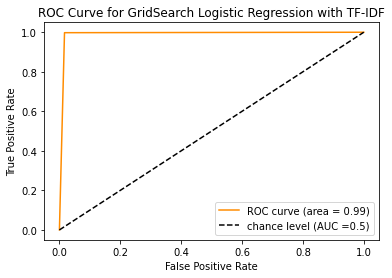

In [75]:
fpr, tpr, thresholds = roc_curve(Y_testset, clf_svc_pred)

#calculating auc
clf_svc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % clf_svc_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GridSearch Logistic Regression with TF-IDF')
plt.legend()
plt.show()